# This notebook is for creating the European-African Mpox transmission model for the December Hackathon Decisionmaker Scenarios

Model editing is unavailable in Terarium at the moment, so I am doing this instead.

### Model requirements: 
- Africa model includes human-to-human, rodent-to-human, and rodent-to-rodent transmission
- European model includes human-to-human, human-to-pet, and pet-to-pet transmission
- Inter-continental mixing between humans
- Both include vaccination

Model is based on [Model A](https://www.mdpi.com/2227-7390/11/5/1121), from *Unfolding the Transmission Dynamics of Monkeypox Virus: An Epidemiological Modelling Analysis*

### Load dependencies

In [16]:
import sympy as sp
import torch
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from mira.metamodel import *
from mira.sources.sympy_ode import template_model_from_sympy_odes
from mira.modeling.amr.petrinet import template_model_to_petrinet_json_file
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model

### Define model variables and parameters

In [2]:
# Time variable
t = sp.symbols("t")

# Time-dependent variables
SH_a, SL_a, EH_a, P_a, IM_a, IS_a, H_a, RH_a, V_a = sp.symbols(
    "SH_a SL_a EH_a P_a IM_a IS_a H_a RH_a V_a", cls=sp.Function
) # African humans
SH_e, SL_e, EH_e, P_e, IM_e, IS_e, H_e, RH_e, V_e = sp.symbols(
    "SH_e SL_e EH_e P_e IM_e IS_e H_e RH_e V_e", cls=sp.Function
) # European humans
SR, ER, IR, RR = sp.symbols("SR ER IR RR", cls=sp.Function) # Rodents
SP, EP, IP, RP = sp.symbols("SP EP IP RP", cls=sp.Function) # Pets

# Parameters
beta_aa, beta_ra, beta_rr, beta_ee, beta_ep, beta_pp, beta_ea, beta_ae = sp.symbols(
    "beta_aa beta_ra beta_rr beta_ee beta_ep beta_pp beta_ea beta_ae"
)
alpha, eta, pi_h, pi_rp, rho, nu, sigma_h, sigma_rp, omega, theta, k1, k2 = sp.symbols(
    "alpha eta pi_h pi_rp rho nu sigma_h sigma_rp omega theta k1 k2"
)
delta_i, delta_h, delta_rp, tau1, tau2, tau3, tau_rp, mu_h, mu_rp = sp.symbols(
    "delta_i delta_h delta_rp tau1 tau2 tau3 tau_rp mu_h mu_rp"
)
lambda_a, lambda_e, lambda_r, lambda_p, vpd_a, vpd_e = sp.symbols(
    "lambda_a lambda_e lambda_r lambda_p vpd_a vpd_e"
)

### Define model equations

In [3]:
# African, European, rodent, and pet populations
N_a = SH_a(t) + SL_a(t) + EH_a(t) + P_a(t) + IM_a(t) + IS_a(t) + H_a(t) + RH_a(t) + V_a(t)
N_e = SH_e(t) + SL_e(t) + EH_e(t) + P_e(t) + IM_e(t) + IS_e(t) + H_e(t) + RH_e(t) + V_e(t)
N_r = SR(t) + ER(t) + IR(t) + RR(t)
N_p = SP(t) + EP(t) + IP(t) + RP(t)

# Force of infection
lambda_a = beta_aa * (alpha*P_a(t) + eta*IM_a(t) + IS_a(t)) / N_a + beta_ea * (alpha*P_e(t) + eta*IM_e(t) + IS_e(t)) / N_e + beta_ra * IR(t) / N_r
lambda_e = beta_ee * (alpha*P_e(t) + eta*IM_e(t) + IS_e(t)) / N_e + beta_ae * (alpha*P_a(t) + eta*IM_a(t) + IS_a(t)) / N_a
lambda_r = beta_rr * IR(t) / N_r
lambda_p = beta_ep * (alpha*P_e(t) + eta*IM_e(t) + IS_e(t)) / N_e + beta_pp * IP(t) / N_r

# System of ODEs
odes = [
    sp.Eq(SL_a(t).diff(t), pi_h * (1 - rho) - nu * lambda_a * SL_a(t) - mu_h * SL_a(t)),
    sp.Eq(SH_a(t).diff(t), pi_h * rho - lambda_a * SH_a(t) - mu_h * SH_a(t) - vpd_a),
    sp.Eq(EH_a(t).diff(t), nu * SL_a(t) * lambda_a + SH_a(t) * lambda_a - (sigma_h + mu_h) * EH_a(t)),
    sp.Eq(P_a(t).diff(t), sigma_h * EH_a(t) - (omega + mu_h) * P_a(t)),
    sp.Eq(IM_a(t).diff(t), omega * P_a(t) - (theta + k1 + tau1 + mu_h) * IM_a(t)),
    sp.Eq(IS_a(t).diff(t), theta * IM_a(t) - (k2 + delta_i + tau2 + mu_h) * IS_a(t)),
    sp.Eq(H_a(t).diff(t), k1 * IM_a(t) + k2 * IS_a(t) - (delta_h + tau3 + mu_h) * H_a(t)),
    sp.Eq(RH_a(t).diff(t), tau1 * IM_a(t) + tau2 * IS_a(t) + tau3 * H_a(t) - mu_h * RH_a(t)),
    sp.Eq(V_a(t).diff(t), vpd_a),
    sp.Eq(SR(t).diff(t), pi_rp - lambda_r * SR(t) - mu_rp * SR(t)),
    sp.Eq(ER(t).diff(t), lambda_r * SR(t) - (sigma_rp + mu_rp) * ER(t)),
    sp.Eq(IR(t).diff(t), sigma_rp * ER(t) - (delta_rp + tau_rp + mu_rp) * IR(t)),
    sp.Eq(RR(t).diff(t), tau_rp * IR(t) - mu_rp * RR(t)),
    sp.Eq(SL_e(t).diff(t), pi_h * (1 - rho) - nu * lambda_e * SL_e(t) - mu_h * SL_e(t)),
    sp.Eq(SH_e(t).diff(t), pi_h * rho - lambda_e * SH_e(t) - mu_h * SH_e(t) - vpd_e),
    sp.Eq(EH_e(t).diff(t), nu * SL_e(t) * lambda_e + SH_e(t) * lambda_e - (sigma_h + mu_h) * EH_e(t)),
    sp.Eq(P_e(t).diff(t), sigma_h * EH_e(t) - (omega + mu_h) * P_e(t)),
    sp.Eq(IM_e(t).diff(t), omega * P_e(t) - (theta + k1 + tau1 + mu_h) * IM_e(t)),
    sp.Eq(IS_e(t).diff(t), theta * IM_e(t) - (k2 + delta_i + tau2 + mu_h) * IS_e(t)),
    sp.Eq(H_e(t).diff(t), k1 * IM_e(t) + k2 * IS_e(t) - (delta_h + tau3 + mu_h) * H_e(t)),
    sp.Eq(RH_e(t).diff(t), tau1 * IM_e(t) + tau2 * IS_e(t) + tau3 * H_e(t) - mu_h * RH_e(t)),
    sp.Eq(V_e(t).diff(t), vpd_e),
    sp.Eq(SP(t).diff(t), pi_rp - lambda_r * SP(t) - mu_rp * SP(t)),
    sp.Eq(EP(t).diff(t), lambda_r * SP(t) - (sigma_rp + mu_rp) * EP(t)),
    sp.Eq(IP(t).diff(t), sigma_rp * EP(t) - (delta_rp + tau_rp + mu_rp) * IP(t)),
    sp.Eq(RP(t).diff(t), tau_rp * IP(t) - mu_rp * RP(t)),
]

### Set concept data

In [4]:
concept_data = {
    'SH_a': {'identifiers': {'ido': '0000514'},
            'context': {'severity': 'low', 'species': 'ncbitaxon:9606'}},
    'SL_a': {'identifiers': {'ido': '0000514'},
            'context': {'severity': 'high', 'species': 'ncbitaxon:9606'}},
    'EH_a': {'identifiers': {'apollosv': '00000154'},
            'context': {'species': 'ncbitaxon:9606'}},
    'P_a': {'identifiers': {'ido': '0000511'},
          'context': {'stage': 'predromal', 'species': 'ncbitaxon:9606'}},
    'IM_a': {'identifiers': {'ido': '0000511'},
           'context': {'stage': 'mild', 'species': 'ncbitaxon:9606'}},
    'IS_a': {'identifiers': {'ido': '0000511'},
           'context': {'stage': 'severe', 'species': 'ncbitaxon:9606'}},
    'H_a': {'identifiers': {'ido': '0000511'},
         'context': {'hospitalization': 'ncit:C25179', 'species': 'ncbitaxon:9606'}},
    'RH_a': {'identifiers': {'ido': '0000592'},
         'context': {'species': 'ncbitaxon:9606'}},
    'V_a': {'identifiers': {'ido': '0000592'}, # Not sure if this is right either
         'context': {'species': 'ncbitaxon:9606'}},
    'SR': {'identifiers': {'ido': '0000514'},
            'context': {'species': 'ncbitaxon:9989'}},
    'ER': {'identifiers': {'apollosv': '00000154'},
            'context': {'species': 'ncbitaxon:9989'}},
    'IR': {'identifiers': {'ido': '0000511'},
           'context': {'species': 'ncbitaxon:9989'}},
    'RR': {'identifiers': {'ido': '0000592'},
            'context': {'species': 'ncbitaxon:9989'}},
    'SH_e': {'identifiers': {'ido': '0000514'},
            'context': {'severity': 'low', 'species': 'ncbitaxon:9606'}},
    'SL_e': {'identifiers': {'ido': '0000514'},
            'context': {'severity': 'high', 'species': 'ncbitaxon:9606'}},
    'EH_e': {'identifiers': {'apollosv': '00000154'},
            'context': {'species': 'ncbitaxon:9606'}},
    'P_e': {'identifiers': {'ido': '0000511'},
          'context': {'stage': 'predromal', 'species': 'ncbitaxon:9606'}},
    'IM_e': {'identifiers': {'ido': '0000511'},
           'context': {'stage': 'mild', 'species': 'ncbitaxon:9606'}},
    'IS_e': {'identifiers': {'ido': '0000511'},
           'context': {'stage': 'severe', 'species': 'ncbitaxon:9606'}},
    'H_e': {'identifiers': {'ido': '0000511'},
         'context': {'hospitalization': 'ncit:C25179', 'species': 'ncbitaxon:9606'}},
    'RH_e': {'identifiers': {'ido': '0000592'},
         'context': {'species': 'ncbitaxon:9606'}},
    'V_e': {'identifiers': {'ido': '0000592'}, # Not sure if this is right either
         'context': {'species': 'ncbitaxon:9606'}},
    'SP': {'identifiers': {'ido': '0000514'}, ### NOT SURE IF THESE ARE CORRECT FOR PETS
            'context': {'species': 'ncbitaxon:9989'}},
    'EP': {'identifiers': {'apollosv': '00000154'},
            'context': {'species': 'ncbitaxon:9989'}},
    'IP': {'identifiers': {'ido': '0000511'},
           'context': {'species': 'ncbitaxon:9989'}},
    'RP': {'identifiers': {'ido': '0000592'},
            'context': {'species': 'ncbitaxon:9989'}},
}

### Set parameter values

In [5]:
parameter_data = {
    'beta_aa': {'value': 0.03},
    'beta_ra': {'value': 0.03045},
    'beta_rr': {'value': 0.025},
    'beta_ee': {'value': 0.03},
    'beta_ep': {'value': 0.02},
    'beta_pp': {'value': 0.025},
    'beta_ea': {'value': 0.00006},
    'beta_ae': {'value': 0.00006},
    'alpha': {'value': 0.75},
    'eta': {'value': 0.8},
    'pi_h': {'value': 8100},
    'pi_rp': {'value': 0.5},
    'rho': {'value': 0.8},
    'nu': {'value': 0.045},
    'sigma_h': {'value': 0.033},
    'sigma_rp': {'value': 0.0083},
    'omega': {'value': 0.0042},
    'theta': {'value': 0.021},
    'k1': {'value': 0.2},
    'k2': {'value': 0.4},
    'delta_i': {'value': 0.0011},
    'delta_h': {'value': 0.001},
    'delta_rp': {'value': 0.057},
    'tau1': {'value': 0.048},
    'tau2': {'value': 0.05},
    'tau3': {'value': 0.056},
    'tau_rp': {'value': 0.083},
    'mu_h': {'value': 0.000045},
    'mu_rp': {'value': 0.002},
    'vpd_a': {'value': 0.0}, # {'value': 100_000.0},
    'vpd_e': {'value': 0.0}, # {'value': 100_000.0},
}

### Set initial conditions

In [6]:
initials = {
    'SH_a': Initial(concept=Concept(name='SH_a'), expression=SympyExprStr(sp.Float(6e7))), # assume pop of Africa is 2x pop of Europe
    'SL_a': Initial(concept=Concept(name='SL_a'), expression=SympyExprStr(sp.Float(12e7))),
    'EH_a': Initial(concept=Concept(name='EH_a'), expression=SympyExprStr(sp.Float(25))),
    'P_a': Initial(concept=Concept(name='P_a'), expression=SympyExprStr(sp.Float(5))),
    'IM_a': Initial(concept=Concept(name='IM_a'), expression=SympyExprStr(sp.Float(0))),
    'IS_a': Initial(concept=Concept(name='IS_a'), expression=SympyExprStr(sp.Float(0))),
    'H_a': Initial(concept=Concept(name='H_a'), expression=SympyExprStr(sp.Float(0))),
    'RH_a': Initial(concept=Concept(name='RH_a'), expression=SympyExprStr(sp.Float(0))),
    'V_a': Initial(concept=Concept(name='V_a'), expression=SympyExprStr(sp.Float(0))),  
    'SR': Initial(concept=Concept(name='SR'), expression=SympyExprStr(sp.Float(6e5))),
    'ER': Initial(concept=Concept(name='ER'), expression=SympyExprStr(sp.Float(800))),
    'IR': Initial(concept=Concept(name='IR'), expression=SympyExprStr(sp.Float(16))),
    'RR': Initial(concept=Concept(name='RR'), expression=SympyExprStr(sp.Float(2))),
    'SH_e': Initial(concept=Concept(name='SH_e'), expression=SympyExprStr(sp.Float(3e7))), # assume pop of Europe is half the pop of Africa
    'SL_e': Initial(concept=Concept(name='SL_e'), expression=SympyExprStr(sp.Float(6e7))),
    'EH_e': Initial(concept=Concept(name='EH_e'), expression=SympyExprStr(sp.Float(0))),
    'P_e': Initial(concept=Concept(name='P_e'), expression=SympyExprStr(sp.Float(0))),
    'IM_e': Initial(concept=Concept(name='IM_e'), expression=SympyExprStr(sp.Float(0))),
    'IS_e': Initial(concept=Concept(name='IS_e'), expression=SympyExprStr(sp.Float(0))),
    'H_e': Initial(concept=Concept(name='H_e'), expression=SympyExprStr(sp.Float(0))),
    'RH_e': Initial(concept=Concept(name='RH_e'), expression=SympyExprStr(sp.Float(0))),
    'V_e': Initial(concept=Concept(name='V_e'), expression=SympyExprStr(sp.Float(0))),
    'SP': Initial(concept=Concept(name='SP'), expression=SympyExprStr(sp.Float(4e7))), # assume ~45% of Europeans have pets
    'EP': Initial(concept=Concept(name='EP'), expression=SympyExprStr(sp.Float(800))),
    'IP': Initial(concept=Concept(name='IP'), expression=SympyExprStr(sp.Float(80))),
    'RP': Initial(concept=Concept(name='RP'), expression=SympyExprStr(sp.Float(10))),
}

### Set observables

In [7]:
observables = {
    'total_infections_a': Observable(name='total_infections_a',
                              expression=SympyExprStr(sp.parse_expr('P_a+IM_a+IS_a+H_a'))),
    'total_infections_e': Observable(name='total_infections_e',
                              expression=SympyExprStr(sp.parse_expr('P_e+IM_e+IS_e+H_e'))),
}

### Set up and save template model

In [8]:
tm = template_model_from_sympy_odes(odes, param_data=parameter_data, concept_data=concept_data)
tm.initials = initials
tm.observables = observables
template_model_to_petrinet_json_file(tm, 'ModelA_africa_europe_rodent_pet.json')
# tm.draw_jupyter()

### Simulate the model

,timepoint_id,sample_id,timepoint_unknown,persistent_mu_h_param,persistent_alpha_param,persistent_beta_aa_param,persistent_beta_ea_param,persistent_beta_ra_param,persistent_eta_param,persistent_nu_param,...,EH_a_state,SH_e_state,SR_state,EH_e_state,SP_state,EP_state,IP_state,RP_state,total_infections_a_observable_state,total_infections_e_observable_state
0,0,0,0.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,25.000000,30000000.0,600000.0000,0.000000,40000000.0,800.000000,80.000000,10.000000,5.000000,0.000000e+00
1,1,0,1.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,83.256958,29998650.0,598800.6875,0.000046,39920052.0,821.735657,75.681709,16.428812,6.753517,7.240178e-07
2,2,0,2.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,151.972305,29997298.0,597604.1875,0.000113,39840288.0,849.435608,72.127502,22.518814,10.606772,3.264933e-06
3,3,0,3.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,229.059982,29995948.0,596409.6875,0.000218,39760668.0,882.123596,69.278549,28.331589,16.868731,8.593475e-06
4,4,0,4.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,312.738647,29994598.0,595216.6250,0.000381,39681112.0,918.953430,67.076431,33.923721,25.784216,1.828554e-05


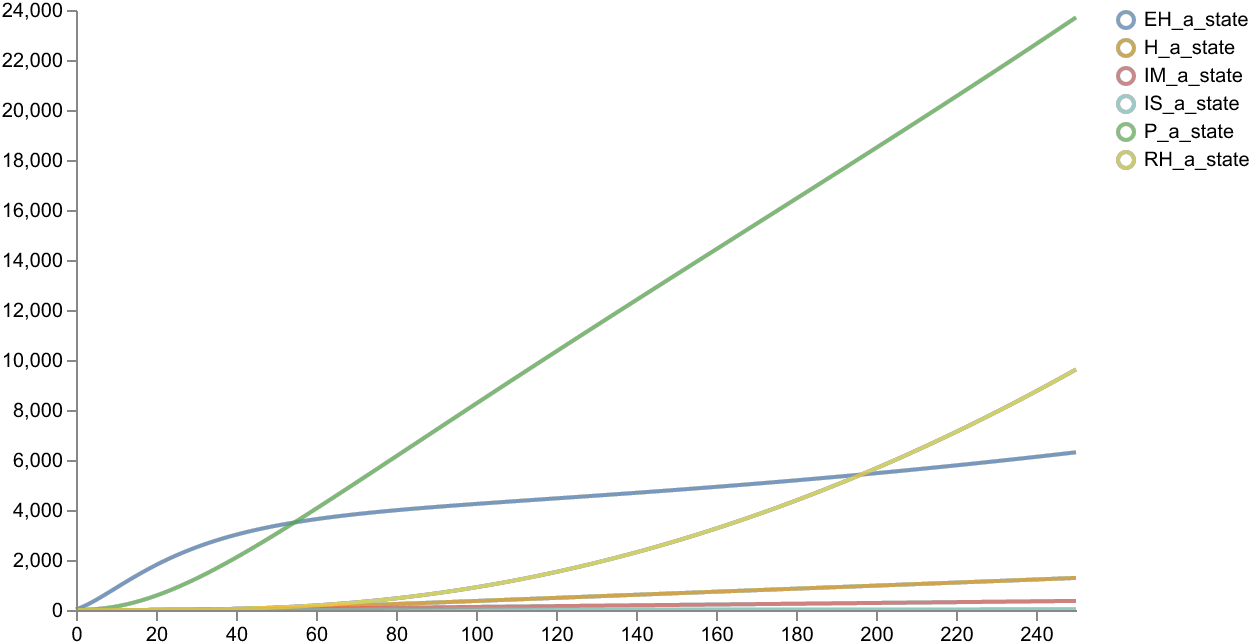

In [9]:
model1 = "ModelA_africa_europe_rodent_pet.json"
model2 = "ModelA_base_petrinet.json"

start_time = 0.0
end_time = 250.0
logging_step_size = 1.0
num_samples = 1

result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for African population
schema = plots.trajectories(result1["data"], keep=["EH_a_state", "H_a_state", "IM_a_state", "IS_a_state", "P_a_state", "RH_a_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

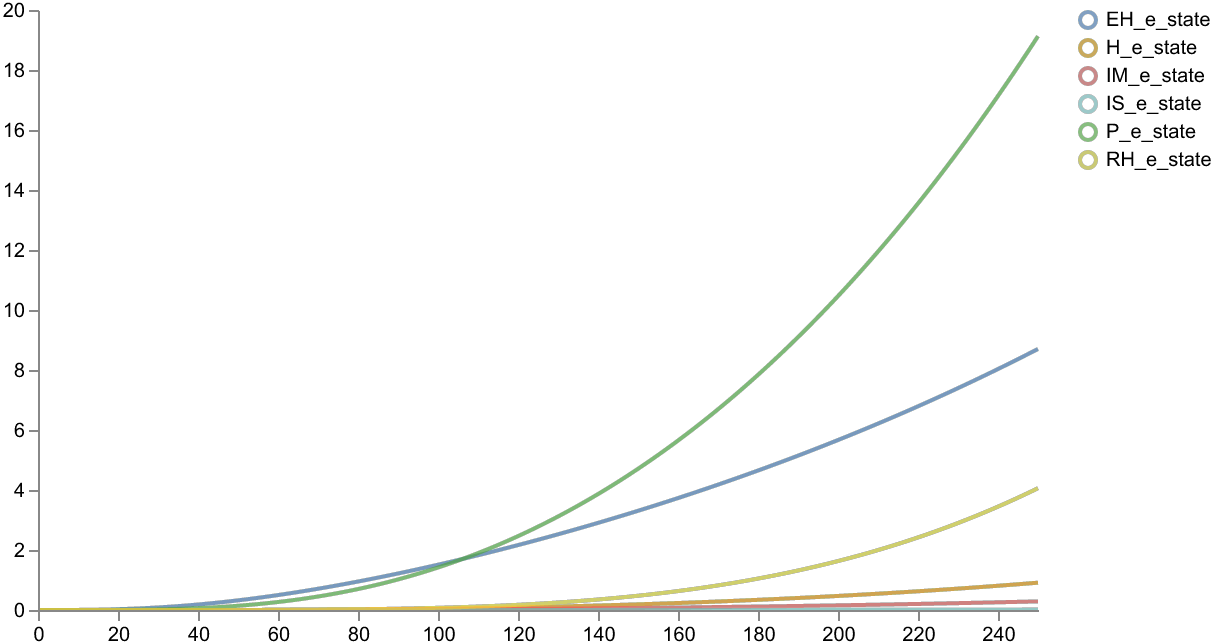

In [10]:
# Plot results for European population
schema = plots.trajectories(result1["data"], keep=["EH_e_state", "H_e_state", "IM_e_state", "IS_e_state", "P_e_state", "RH_e_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

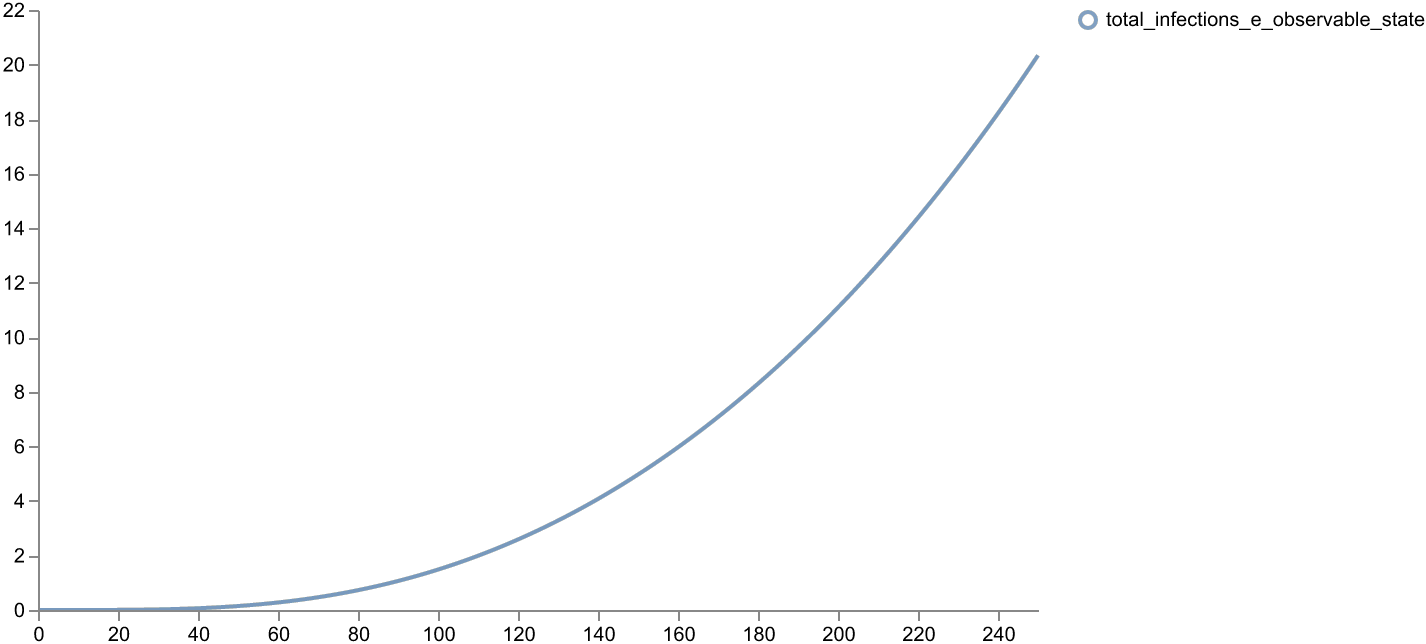

In [11]:
# Plot total infections for European population
schema = plots.trajectories(result1["data"], keep=".*e_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

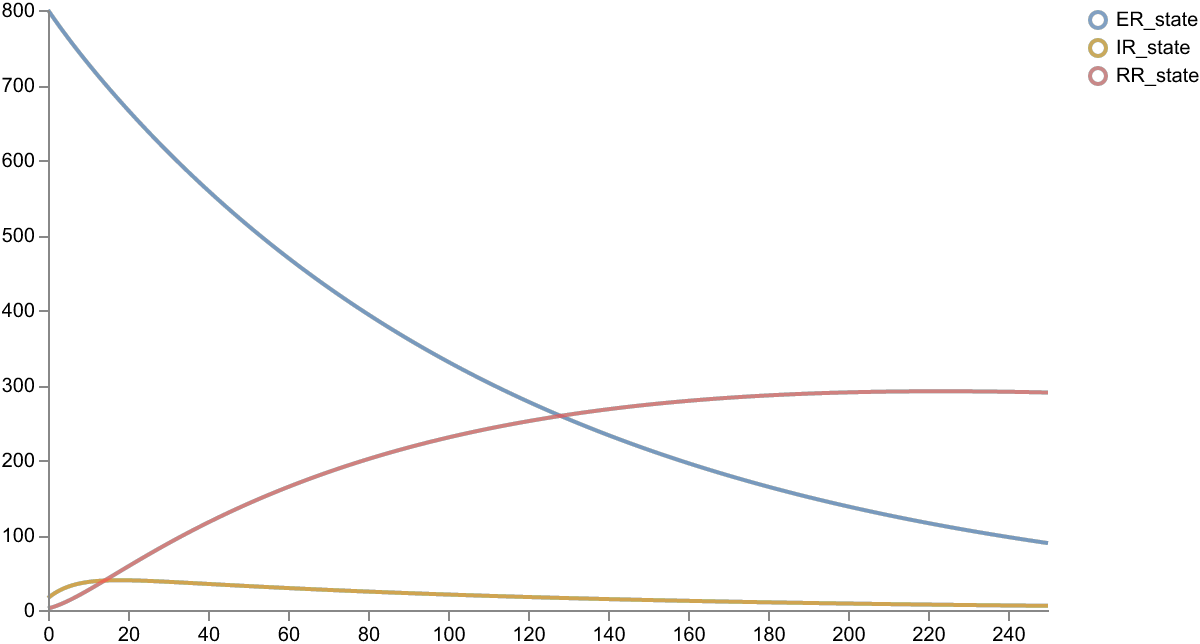

In [12]:
# Plot results for rodent population
schema = plots.trajectories(result1["data"], keep=["ER_state", "IR_state", "RR_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

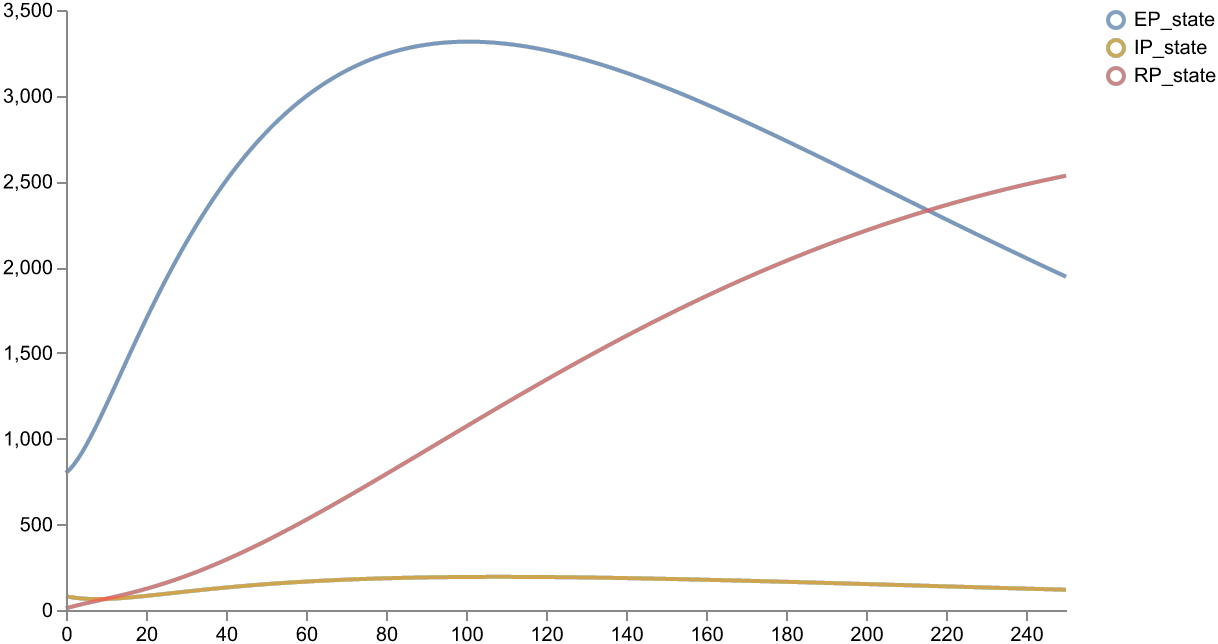

In [13]:
# Plot results for pet population
schema = plots.trajectories(result1["data"], keep=["EP_state", "IP_state", "RP_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

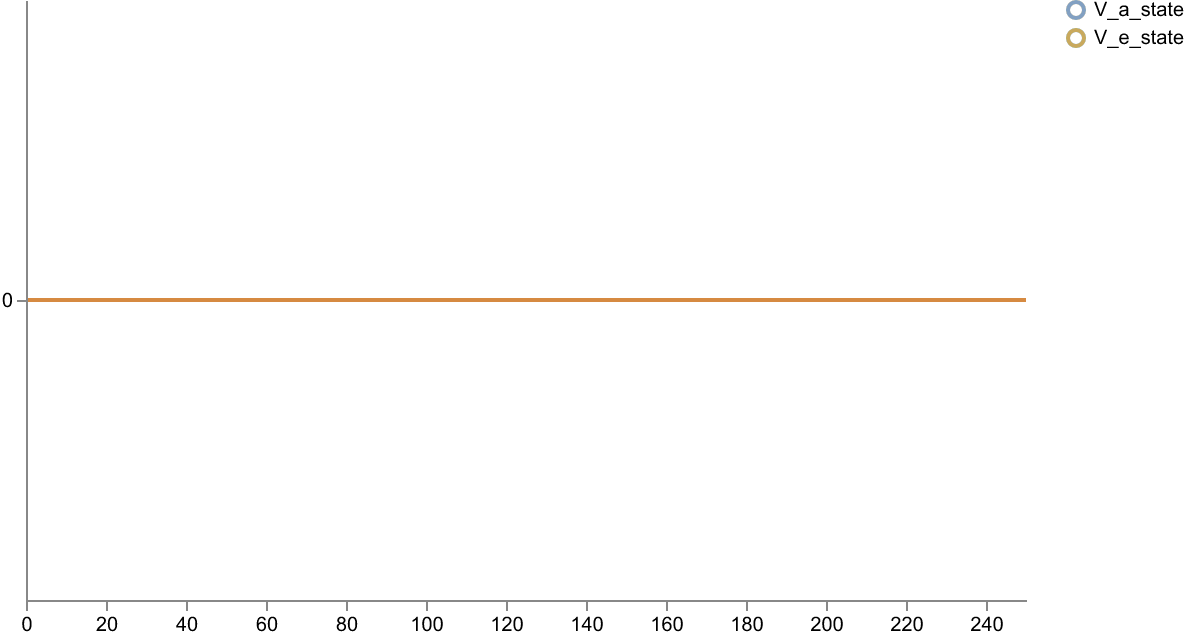

In [14]:
# Plot results for vaccinated population
schema = plots.trajectories(result1["data"], keep=["V_a_state", "V_e_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Case I: Send all of the vaccine supply to Africa, assume 25 million doses available

,timepoint_id,sample_id,timepoint_unknown,persistent_mu_h_param,persistent_alpha_param,persistent_beta_aa_param,persistent_beta_ea_param,persistent_beta_ra_param,persistent_eta_param,persistent_nu_param,...,EH_a_state,SH_e_state,SR_state,EH_e_state,SP_state,EP_state,IP_state,RP_state,total_infections_a_observable_state,total_infections_e_observable_state
0,0,0,0.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,25.000000,30000000.0,600000.0000,0.000000,40000000.0,800.000000,80.000000,10.000000,5.000000,0.000000e+00
1,1,0,1.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,83.256958,29998650.0,598800.6875,0.000046,39920052.0,821.735657,75.681709,16.428812,6.753517,7.240178e-07
2,2,0,2.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,151.915894,29997298.0,597603.6875,0.000113,39840260.0,849.435608,72.127518,22.518816,10.606165,3.264926e-06
3,3,0,3.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,228.815796,29995950.0,596408.9375,0.000218,39760616.0,882.122742,69.278488,28.331587,16.863564,8.593216e-06
4,4,0,4.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,312.152100,29994604.0,595216.9375,0.000381,39681120.0,918.953857,67.076424,33.923862,25.765764,1.828345e-05


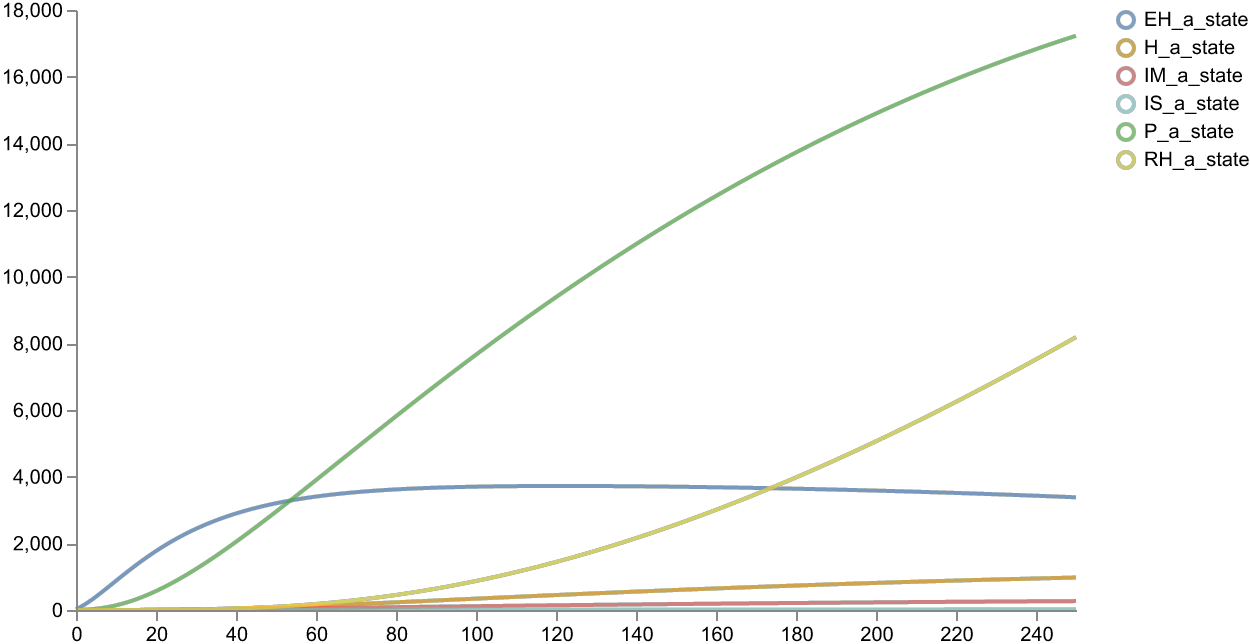

In [17]:
# Simulate the model with 100,000 Africans vaccinated per day, starting at time t = 1
result2 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time,
                         static_parameter_interventions={torch.tensor(1.0): {"vpd_a": torch.tensor(100_000.0)}}
                         )
display(result2['data'].head())

# Plot results for African population
schema = plots.trajectories(result2["data"], keep=["EH_a_state", "H_a_state", "IM_a_state", "IS_a_state", "P_a_state", "RH_a_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

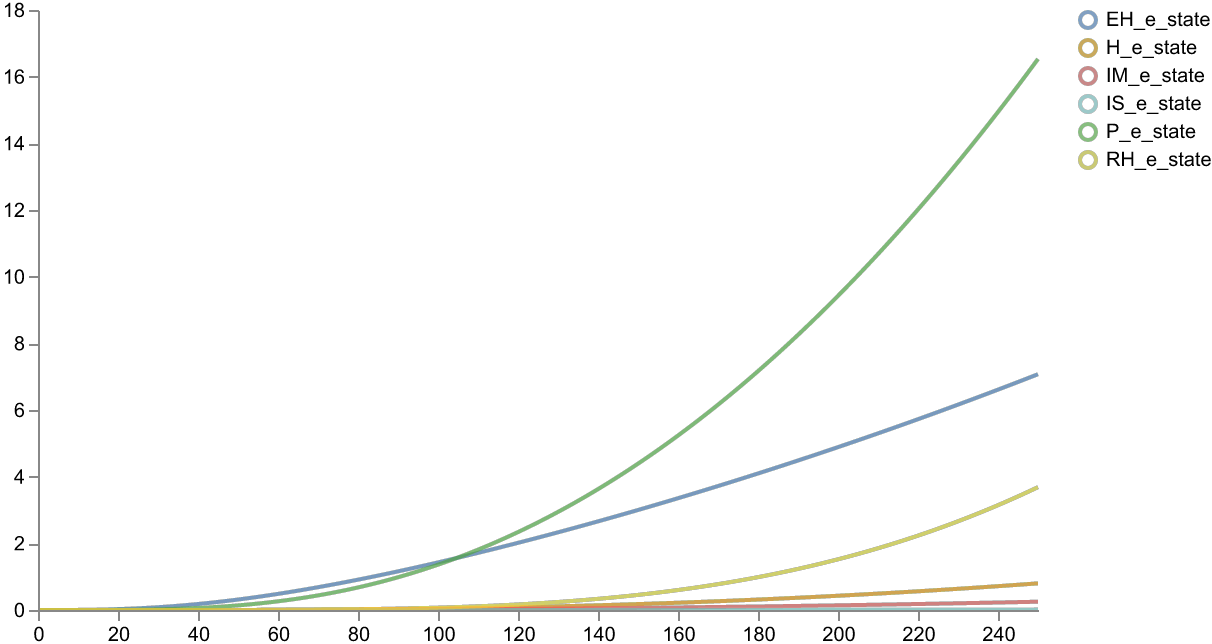

In [18]:
# Plot results for European population
schema = plots.trajectories(result2["data"], keep=["EH_e_state", "H_e_state", "IM_e_state", "IS_e_state", "P_e_state", "RH_e_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

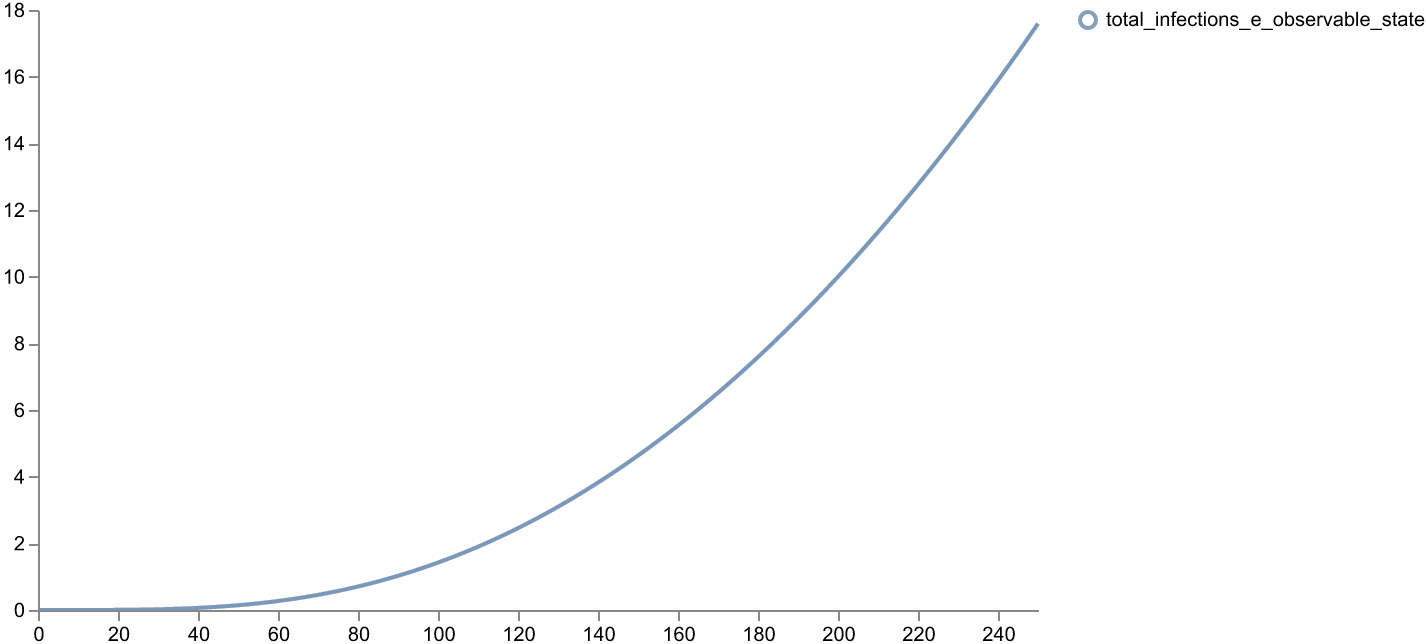

In [19]:
# Plot total infections for European population
schema = plots.trajectories(result2["data"], keep=".*e_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

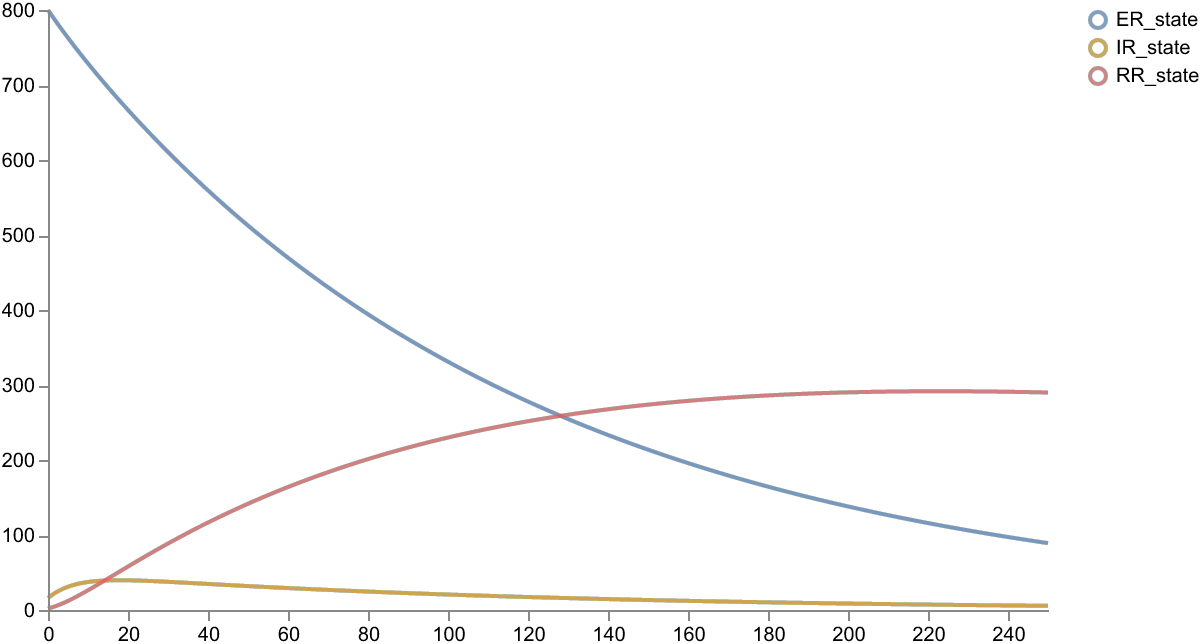

In [20]:
# Plot results for rodent population
schema = plots.trajectories(result2["data"], keep=["ER_state", "IR_state", "RR_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

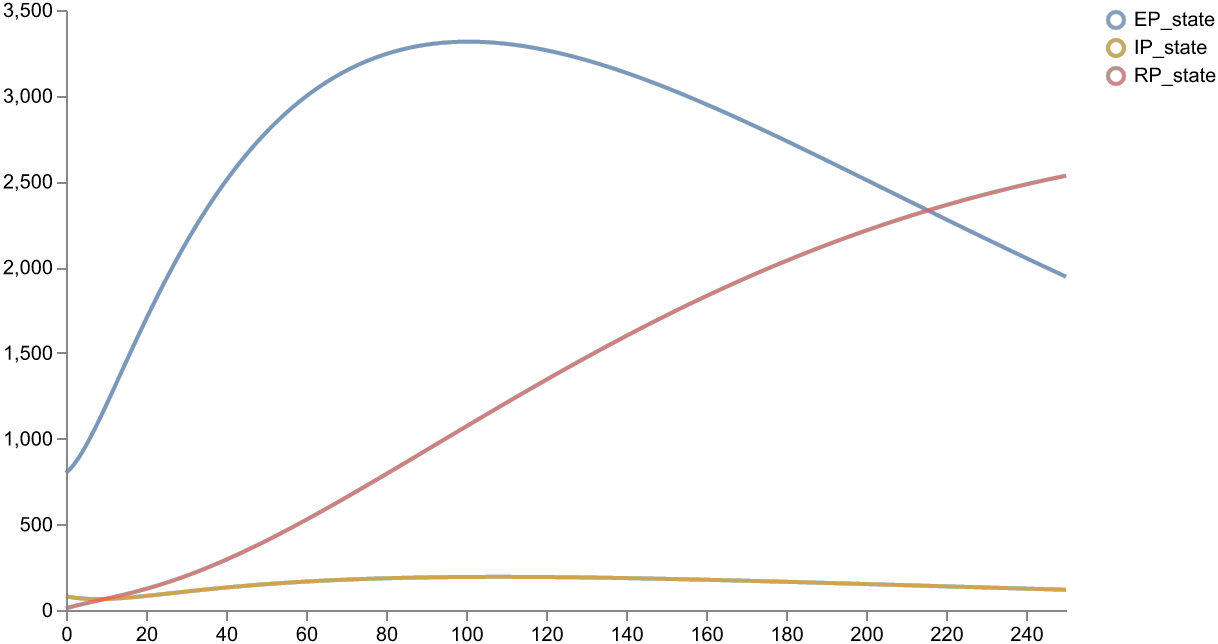

In [21]:
# Plot results for pet population
schema = plots.trajectories(result2["data"], keep=["EP_state", "IP_state", "RP_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

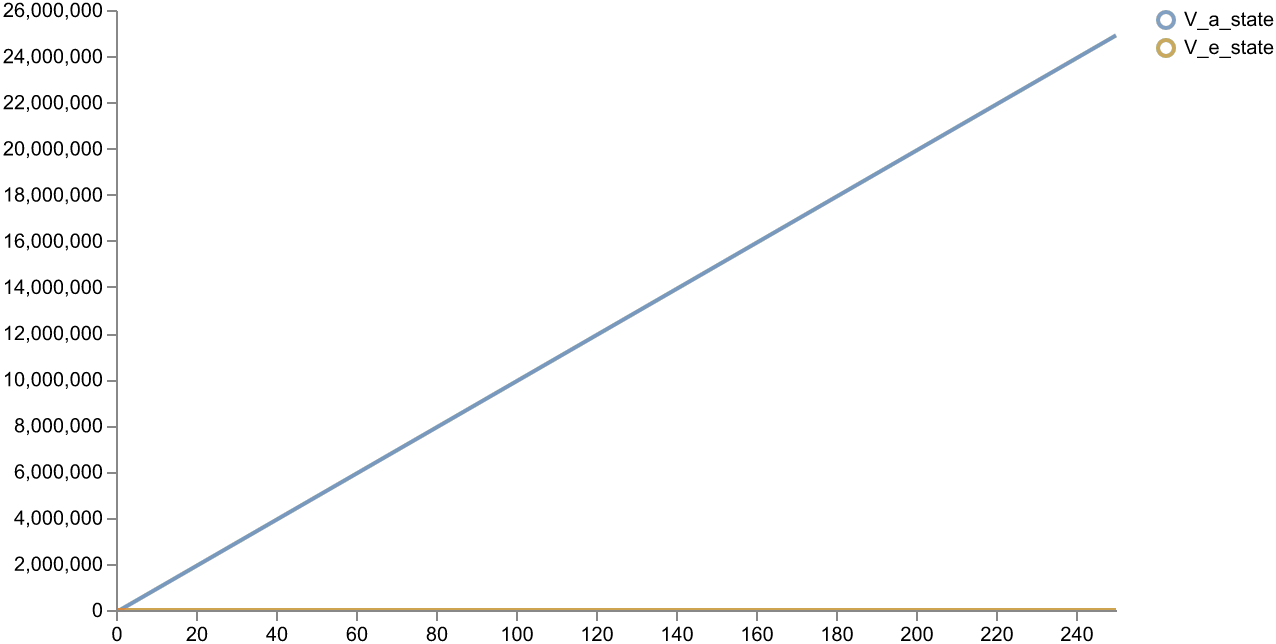

In [22]:
# Plot results for vaccinated population
schema = plots.trajectories(result2["data"], keep=["V_a_state", "V_e_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Case II: Keep all of the vaccine supply in Europe

,timepoint_id,sample_id,timepoint_unknown,persistent_mu_h_param,persistent_alpha_param,persistent_beta_aa_param,persistent_beta_ea_param,persistent_beta_ra_param,persistent_eta_param,persistent_nu_param,...,EH_a_state,SH_e_state,SR_state,EH_e_state,SP_state,EP_state,IP_state,RP_state,total_infections_a_observable_state,total_infections_e_observable_state
0,0,0,0.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,25.000000,30000000.0,600000.0000,0.000000,40000000.0,800.000000,80.000000,10.000000,5.000000,0.000000e+00
1,1,0,1.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,83.256958,29998650.0,598800.6875,0.000046,39920052.0,821.735657,75.681709,16.428812,6.753517,7.240178e-07
2,2,0,2.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,151.915894,29997298.0,597603.6875,0.000113,39840260.0,849.435608,72.127518,22.518816,10.606165,3.264926e-06
3,3,0,3.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,228.815796,29995950.0,596408.9375,0.000218,39760616.0,882.122742,69.278488,28.331587,16.863564,8.593216e-06
4,4,0,4.0,0.000045,0.75,0.03,0.00006,0.03045,0.8,0.045,...,312.152100,29994604.0,595216.9375,0.000381,39681120.0,918.953857,67.076424,33.923862,25.765764,1.828345e-05


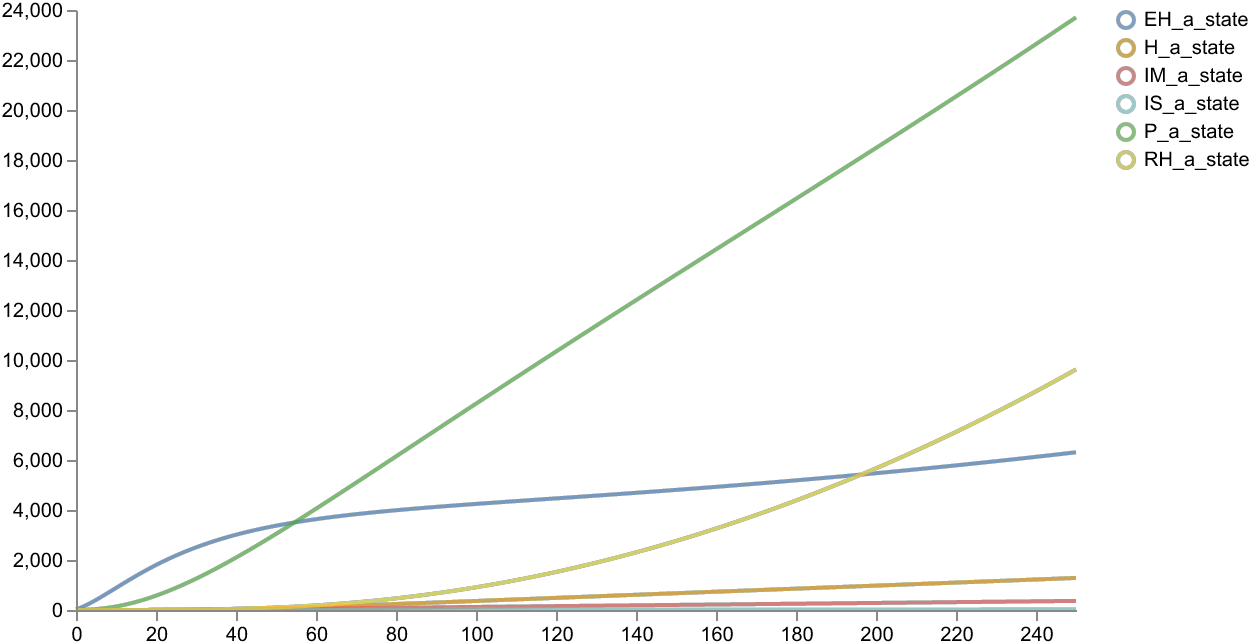

In [23]:
# Simulate the model with 100,000 Europeans vaccinated per day, starting at time t = 1
result3 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time,
                         static_parameter_interventions={torch.tensor(1.0): {"vpd_e": torch.tensor(100_000.0)}}
                         )
display(result2['data'].head())

# Plot results for African population
schema = plots.trajectories(result3["data"], keep=["EH_a_state", "H_a_state", "IM_a_state", "IS_a_state", "P_a_state", "RH_a_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

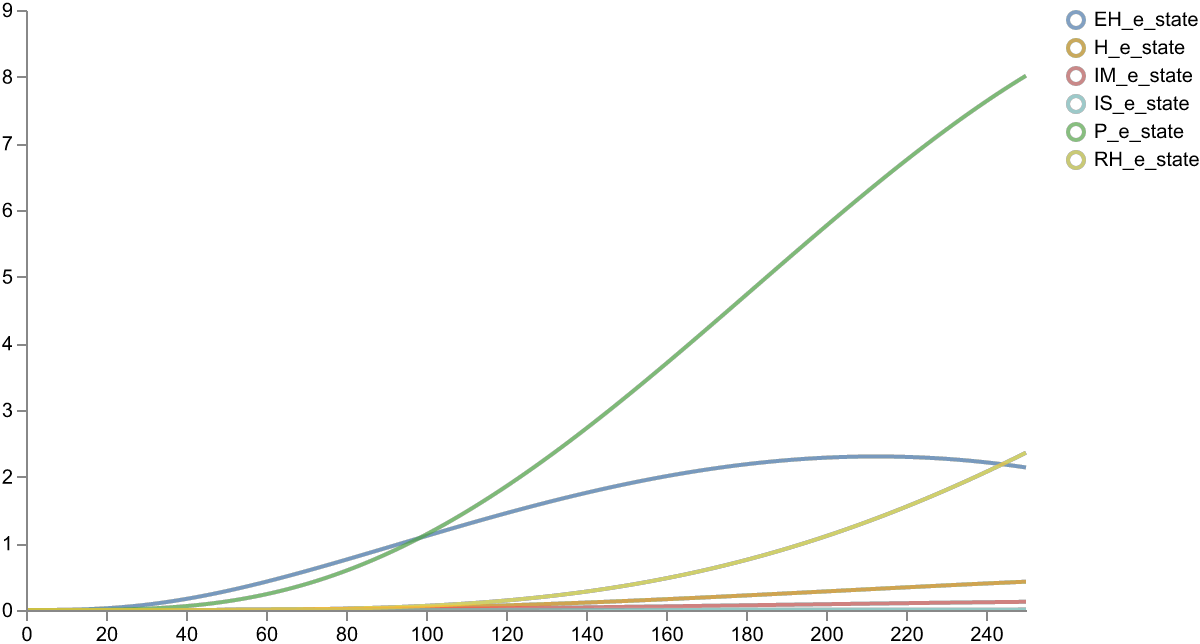

In [24]:
# Plot results for European population
schema = plots.trajectories(result3["data"], keep=["EH_e_state", "H_e_state", "IM_e_state", "IS_e_state", "P_e_state", "RH_e_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

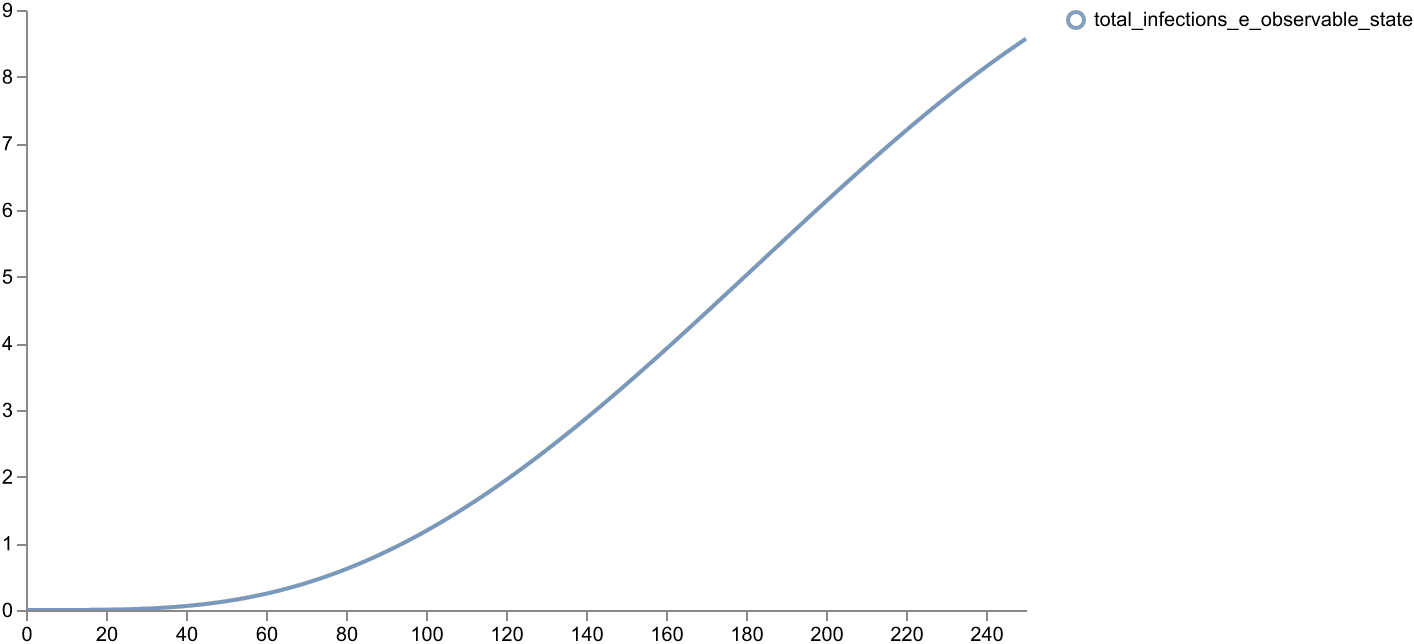

In [25]:
# Plot total infections for European population
schema = plots.trajectories(result3["data"], keep=".*e_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

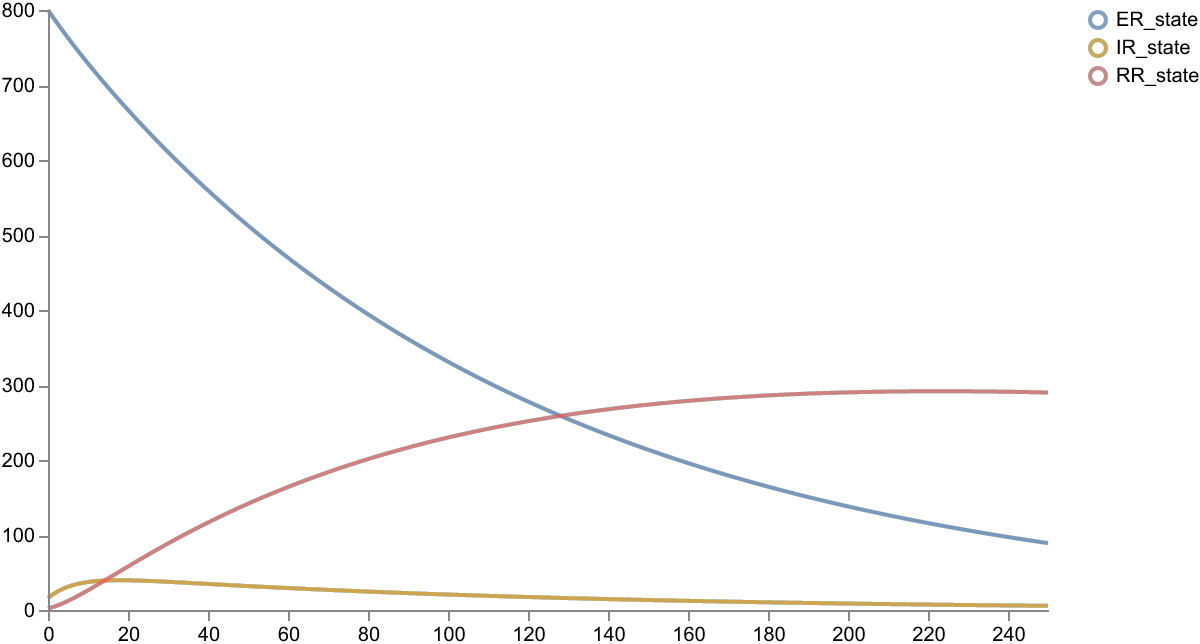

In [26]:
# Plot results for rodent population
schema = plots.trajectories(result3["data"], keep=["ER_state", "IR_state", "RR_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

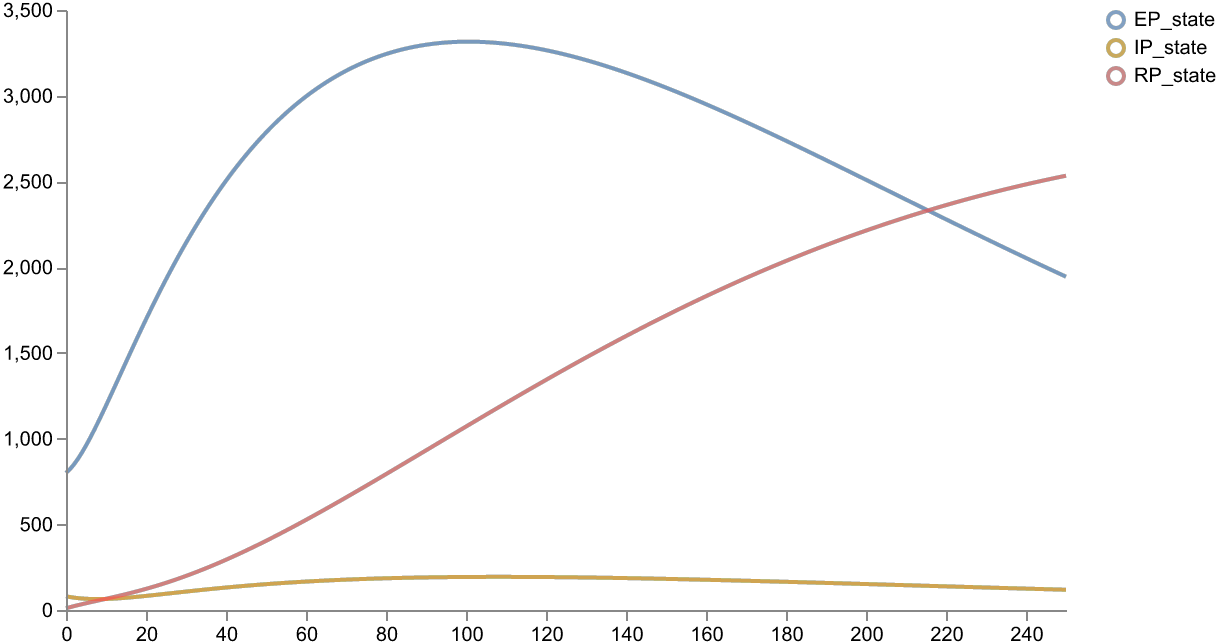

In [27]:
# Plot results for pet population
schema = plots.trajectories(result3["data"], keep=["EP_state", "IP_state", "RP_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

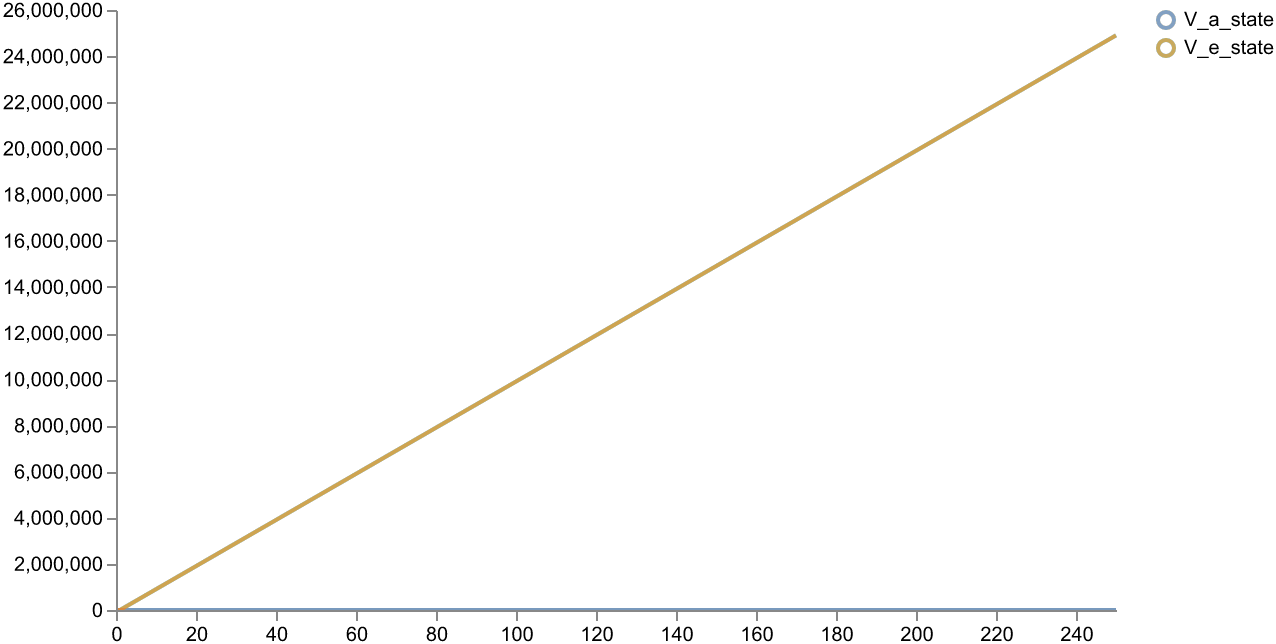

In [28]:
# Plot results for vaccinated population
schema = plots.trajectories(result3["data"], keep=["V_a_state", "V_e_state"])
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)